## Arellano (2008) With Collocations

In the following code we will solve the Arellano (2008) with collocations method. For that we will use the translation of the `CompEcon` package to `Julia`.


The main equations of the Arellano model are:

\begin{equation}
\begin{aligned}
V_{c}(b,y) & = \max_{b'\geq -Z}\left\{u(c(b')) + \beta\int{}V(b',y')P(y,y')dy'\right\} \\
V_{d} & = u(h(y)) + \beta\int{}\left[\theta V(0,y') + (1-\theta)V_{d}(y')\right]P(y,y')dy' \\
V(b,y) & = \max{}\left\{V_{c}(b,y);V_{d}(y)\right\}
\end{aligned}
\end{equation}


The government is going to default when $V_{c}(b,y)<V_{d}(y)$, and the probability of having default next period is
\begin{equation}
\delta(b',y)\equiv\int{}\mathbf{1}\left\{V_{c}(b',y')< V_{d}(y')\right\}P(y,y')dy'
\end{equation}


Finally, the zero profit condition implies:
\begin{equation}
q(b',y) = \frac{1-\delta(b',y)}{1+r}
\end{equation}


#### Collocations Version

The translation to the collocations version implies the following system of equations:

\begin{equation}
\begin{aligned}
\Phi(b,y;\omega_{c}) & = \max_{b'\geq -Z}\left\{u(c(b')) + \beta\Phi(b',y;\omega_{e})\right\} \\
\Phi(y;\omega_{d}) & = u(h(y)) + \beta\sum_{y'\in Y}\Pi[y,y']\left[\theta\Phi(0,y';\omega_{c}) + (1-\theta)\Phi(y';\omega_{d})\right] \\
\Phi(b,y;\omega_{e}) & = (\Pi\otimes\mathbf{I_{N_{b}}})\max\left\{\Phi(b,y';\omega_{c});\Phi(y';\omega_{d})\right\}\\
V(b,y) & = \max\left\{\Phi(b,y;\omega_{c});\Phi(y;\omega_{d})\right\}
\end{aligned}
\end{equation}


Note that $\Phi(b,y;\omega)$ is an abbreviation for $\sum_{j\in N_{y}N_{b}}\phi(b,y)_{j}\omega_{j}$, where $\phi(b,y)$ is a row vector.


The advantage of separating the value function from its expected value is that it greatly increases the computation speed, since we do not have to compute the expecation for each optimization iteration. We can solve $V$ and $V_{e}$ separately and then solve the system.


We are going to choose $N_{y}=10$ collocation nodes for the income process and $N_{b}=10$ collocation nodes for the level of debt. Then the set of collocation nodes is $\mathbf{s}=[\mathbf{1}_{N_{y}}\otimes{}\mathbf{b},\mathbf{y}\otimes\mathbf{1}_{N_{b}}]$, so that $\mathbf{s}$ is of dimension $N\times{}2$ with $N=N_{y}\times{}N_{b}$.

We chose linear splines for both, income and bonds.


For better understanding, we write down the problem in matrix form. All the variables are now vectors. Let $\Phi_{x}$ be the basis structure for variable $x$.

\begin{equation}
\begin{aligned}
\Phi(s)\omega_{c} & = \max_{b'\in Z}\left\{u(c(b')) + \beta\Phi([b',y])\omega_{e}\right\} \\
\Phi_{d}(y)\omega_{d} & = u(h(y)) + \beta\Pi\left[\theta\Phi([0,y'])\omega_{c} + (1-\theta)\Phi_{d}(y')\omega_{d}\right] \\
\Phi(s)\omega_{e} & = (\Pi\otimes\mathbf{I_{N_{b}}})\max\left\{\Phi([b,y'])\omega_{c};\mathbf{1_{N_{b}}}\otimes\Phi_{d}(y)\omega_{d}\right\}\\
\end{aligned}
\end{equation}


For the second equation, note that $[0,y]$ is just the block of the state vector in which $s=(b=0,y)$, which is of size $N_{y}\times1$. Then, $\Phi([0,y])$ is of size $N_{y}\times N$ and $\Phi([0,y])\omega_{c}$ is of size $N_{y}\times1$. Then $\Pi\left[\dot{}\right]$ is of size $N_{y}\times1$.


The way to solve by iteration is:
1. Guess some initial weights $\omega_{c},\omega_{e},\omega_{d}$.
2. Compute the RHS of the three equations.
3. Since the $\Phi_{x}$ matrices are invertible, we can get new vectors of coefficients by pre-multiplying the RHS by the $\Phi_{x}$ matrices.
4. Use output as new guess and iterate until convergence in coefficients.

In what follows we define the ArellanoEconomy type, which now includes collocation parameters.

In [2]:
using QuantEcon, CompEcon, Interpolations

type ArellanoEconomy
    # Model Parameters
    β::Float64
    γ::Float64
    r::Float64
    ρ::Float64
    η::Float64
    θ::Float64

    # Grid Parameters
    ny::Int64
    nB::Int64
    b_low::Float64 # lower bound for Bgrid
    b_up::Float64  # upper bounds for Bgrid
    ygrid::Array{Float64, 1}
    ydef::Array{Float64, 1}
    Bgrid::Array{Float64, 1}
    Π::Array{Float64, 2}

    # Collocation Specification
    basis::Basis
    bs::BasisStructure
    Φ::SparseMatrixCSC{Float64,Int}
    Φd::SparseMatrixCSC{Float64,Int}
    snodes::Matrix{Float64}
    ωe::Array{Float64}
    ωc::Array{Float64}
    ωd::Array{Float64}
    n_b::Int64
    n_y::Int64
    
    # Value and Policy Functions
    vf::Array{Float64, 2}
    vd::Array{Float64, 2}
    vc::Array{Float64, 2}
    policy::Array{Float64, 2}
    q::Array{Float64, 2}
    defprob::Array{Float64, 2}
    
    # Setting Parameters for Optimization
    tol::Float64
    maxit::Int
end

Generate the ArellanoEconomy function that will give key values to the ArellanoEconomy type.
Later one we can change particular values of the parameters by typing ArellanoEconomy(param=value).

In [17]:
function ArellanoEconomy(;β=.953,
                          γ=2.,
                          r=0.017,
                          ρ=0.945,
                          η=0.025,
                          θ=0.282,
                          ny=15,
                          nB=15,
                          b_low=-.4,
                          b_up=.4,
                          tol=1e-9,
                          maxit=2000)

    # Create Grids and Discretize the Stochastic Process
    Bgrid = collect(linspace(b_low, b_up, nB))
    res_mark = tauchen(ny, ρ, η)
    Π = res_mark.p
    ly = res_mark.state_values
    ygrid = exp(ly)
    
    # Build Interpolation Basis
    B_params = SplineParams(nB,b_low,b_up,3)
#     B_params = ChebParams(nB,b_low,b_up)
    y_params = LinParams(ygrid, 0)
    basis = Basis(B_params,y_params)
    snodes, (B_nodes,y_nodes) = nodes(basis)
    n_b = length(nodes(basis.params[1]))
    n_y = length(nodes(basis.params[2]))
    bs = BasisStructure(basis, Direct(), snodes, [0,0])
    Φ = convert(Expanded, bs).vals[1]
    Φd = BasisStructure(basis[2], Expanded(), nodes(basis.params[2]), [0]).vals[1]
    ωe = ones(size(snodes,1),1)*0.1
    ωc = ones(size(snodes,1),1)*0.1
    ωd = ones(n_y)*0.1
    
    ydef = h(nodes(basis.params[2])) 

    # Define value functions (Notice ordered different than Python to take
    # advantage of column major layout of Julia)
    vf = zeros(n_b, n_y)
    vd = zeros(1, n_y)
    vc = zeros(n_b, n_y)
    policy = Array(Int, n_b, n_y)
    q = ones(n_y, n_b) .* (1 / (1 + r))
    defprob = Array(Float64, n_y, n_b)

    return ArellanoEconomy(β, γ, r, ρ, η, θ, ny, nB, b_low, b_up, ygrid, ydef, Bgrid, Π, basis, bs, Φ, Φd,
            snodes, ωe, ωc, ωd, n_b, n_y, vf, vd, vc, policy, q, defprob, tol, maxit)
end

ArellanoEconomy

In [18]:
function interp_q(ae::ArellanoEconomy,bp)
    # q is a 2D function. Will interpolate it. Need to take the transpose of q since when we do the reshape
    # for the policy, the matrix will be of ys in the rows and bs in the columns (in the bp vector we have blocks
    # marked by the bs)
    
    bp = reshape(bp,ae.n_y,ae.n_b)
    knots = (nodes(ae.basis.params[2]),nodes(ae.basis.params[1]))
    itp   = interpolate(knots, ae.q, (Gridded(Constant()), Gridded(Linear())))
    itp2 = extrapolate(itp, Flat())
    
    q_interp = Array(Float64,ae.n_y,ae.n_b)
    
    for (i_y,y_v) in enumerate(nodes(ae.basis.params[2]))
        for i_b=1:ae.n_b
            b_val = bp[i_y,i_b]
            q_interp[i_y,i_b] = itp[y_v,b_val]
        end
    end
    
    q_interp = vec(q_interp)
    return q_interp
end


h(grid::Vector{Float64}) = min(.969 * mean(grid), grid)

u(ae::ArellanoEconomy, sn, bp) = vec(g(ae,bp,sn).^(1 - ae.γ) / (1 - ae.γ))
g(ae::ArellanoEconomy, bp, sn=ae.snodes) = sn[:,2]+sn[:,1]-interp_q(ae,bp).*bp # Budget Constraint

g (generic function with 2 methods)

In [19]:
# Write Down the Otimization Problem
function obj_fun(ae::ArellanoEconomy)
    
    function obj(bp)
        Φ_bp = BasisStructure(ae.basis[1], Expanded(), bp, [0]).vals[1]
        Φ = row_kron(ae.bs.vals[2],Φ_bp)
        rhs = vec(u(ae, ae.snodes, bp) + ae.β*Φ*ae.ωe)
        return rhs
    end
    
    
    lb_b = ae.b_low*ones(ae.n_b*ae.n_y)
    ub_b = ae.snodes[:,2]-0.01
    x_sol,f_sol = golden_method(obj,lb_b,ub_b)
    
end

obj_fun (generic function with 1 method)

In [20]:
# Write Down the One-Step Function

function one_step_update!(ae::ArellanoEconomy)
    # Approach 2:
    # Given (ωc,ωd), get ωe'. With ωc and ωd get ωd'. With ωe' get ωc'.
    rhs_e = vec(kron(ae.Π,eye(ae.n_b))*max(ae.Φ*ae.ωc,repmat(ae.Φd*ae.ωd,ae.n_b)))
    ae.ωe = ae.Φ\rhs_e
    
    ind = searchsortedfirst(ae.snodes[:,1], 0.0)
    Vc = ae.Φ[ind:ind+ae.n_y-1,:]*ae.ωc 
    rhs_d = vec(ae.ydef.^(1 - ae.γ) / (1 - ae.γ)+ae.β*ae.Π*(ae.θ*Vc + (1-ae.θ)*ae.Φd*ae.ωd))
    ae.ωd = ae.Φd\rhs_d
    
    xsol,rhs_c = obj_fun(ae)
    ae.ωc = ae.Φ\rhs_c
    
    
    
    Void
end


function compute_prices!(ae::ArellanoEconomy)
    
    # Create default values with a matching size
    default_states = repmat(ae.Φd*ae.ωd,ae.n_b) .> ae.Φ*ae.ωc
    
    # Update default probabilities and prices
    int = reshape(default_states,ae.n_y,ae.n_b)
    copy!(ae.defprob, ae.Π*int)
    copy!(ae.q, (1 - ae.defprob) / (1 + ae.r))

    Void
end


function iter!(ae::ArellanoEconomy)
    iteration = 0
    dif = 1
    
#     P_Φ = kron(ae.Π, eye(ae.n_b))*ae.Φ
    
    while dif>ae.tol
        iteration +=1
        if iteration > ae.maxit
            @printf("resid_c is %.3f\n",resid_c)
            @printf("resid_d is %.3f\n",resid_d)
            @printf("resid_e is %.3f\n",resid_e)
            break
        else
            ωc0 = copy(ae.ωc)
            ωd0 = copy(ae.ωd)
            ωe0 = copy(ae.ωe)
            
            one_step_update!(ae)
            
            # Update Prices
            compute_prices!(ae)
            
            resid_c = norm(ae.ωc - ωc0)
            resid_d = norm(ae.ωd - ωd0)
            resid_e = norm(ae.ωe - ωe0)
            
            dif = max(resid_c,resid_d,resid_e)
#             @printf("Iteration %d with distance %.3f\n", iteration, dif)
        end
    end
    
    @printf("The total number of iterations was %d.\n", iteration)
    @printf("The distance is %.5f.\n", dif)
end
    


iter! (generic function with 1 method)

In [21]:
ae = ArellanoEconomy()
@time iter!(ae)

The total number of iterations was 116.
The distance is NaN.
  4.220799 seconds (13.93 M allocations: 4.830 GB, 22.21% gc time)


Next I am going to:
1. Take a finer grid for debt
2. Using the $\Phi$s and the solutions for the $\omega$s, I am going to compute the value functions for the finer grid.
3. Compute teh default states and default probability $\delta(\dot{})$.
4. Compute the pricing kernel $q(\dot{})$

In [15]:
function finer_grid(ae::ArellanoEconomy,NN) 

    B_params_finer = SplineParams(NN,ae.b_low,ae.b_up,1)
    y_params = LinParams(ae.ygrid, 0)
    basis_finer    = Basis(B_params_finer,y_params)
    snodes_finer, (B_nodes_finer,y_nodes_finer) = nodes(basis_finer)

    n_b_finer = length(nodes(basis_finer.params[1]))
    n_y_finer = length(nodes(basis_finer.params[2]))
    bs_finer  = BasisStructure(basis_finer, Direct(), snodes_finer, [0 0])
    
    Φ_int   = BasisStructure(ae.basis[1], Expanded(), snodes_finer[:,1], [0]).vals[1]
    Φ_finer = row_kron(bs_finer.vals[2],Φ_int)

    VC = Φ_finer*ae.ωc
    VE = Φ_finer*ae.ωe
    VD = repmat(ae.Φd*ae.ωd,NN)
    VF = reshape(max(VD,VC),ae.n_y,NN)
    
    # Create default values with a matching size
    default_states_finer = VD .> VC

    # Update default probabilities and prices
    int = reshape(default_states_finer,ae.n_y,NN)
    defprob_finer = ae.Π*int
    q_finer = (1 - defprob_finer) / (1 + ae.r)

    return VC,VE,VD,VF,default_states_finer,defprob_finer,q_finer,B_nodes_finer
end

NN = 2000

VC,VE,VD,VF,default_states_finer,defprob_finer,q_finer,B_nodes_finer = finer_grid(ae,NN)

q_finer_transpose = q_finer';


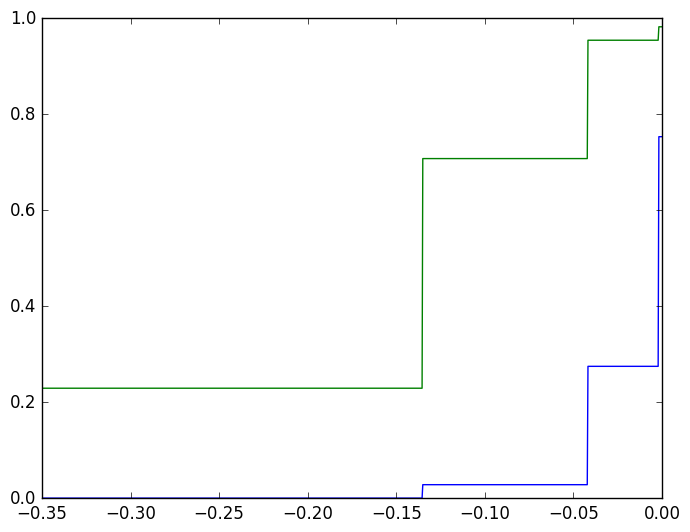

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x317f888d0>
 PyObject <matplotlib.lines.Line2D object at 0x31f07ef90>

In [16]:
# using Gadfly, Compose, ColorTypes, DataFrames

# Create "Y High" and "Y Low" values as 5% devs from mean

grid_y = nodes(ae.basis.params[2])
grid_b = nodes(ae.basis.params[1])

high, low = mean(grid_y)*1.05, mean(grid_y)*.92
iy_high, iy_low = map(x->searchsortedfirst(grid_y, x), (high, low))

# Extract a suitable plot grid
x = Float64[]
q_low = Float64[]
q_high = Float64[]
for i=1:NN
    b = B_nodes_finer[i]
    if -0.35 <= b <= 0  # To match fig 3 of Arellano
        push!(x, b)
        push!(q_low, q_finer_transpose[i,7])
        push!(q_high, q_finer_transpose[i,9])
    end
end

# generate plot
plot(x,[q_low q_high])